# Aggregate selective studies data

Define **selective studies** as studies that 
- Have at these one of the following tags:
    > ['knock_out','gene_silence','RT_qPCR','gene_knockout','genetic_transformation']
- have at least 1 gene manipulated.
- are not one of the studies in `match_summary.csv`

##### Output file path: `lipid_selection/data/intermediate_data_02/selective_studies.pk`
Output format:

| transcript_id | s_num_detected | s_num_sampled |s_num_no_effect | s_proportion | s_source                 | annotation_version |
|---------------|------------------|-----------------|------------------|----------------|----------------------------|--------------------|
| `<string>`    | `<int>`          | `<int>`         | `<float>`        | `<float>`      | `'Firstauthor_year'` | `v5.5`             |




##### Output file path: `lipid_selection/data/intermediate_data_02/selective_studies_reduced.pk`
Output format:

| transcript_id | s_num_detected | s_num_sampled |s_num_no_effect | s_proportion | s_source                 | annotation_version |
|---------------|------------------|-----------------|------------------|----------------|----------------------------|--------------------|
| `<string>`    | `<int>`          | `<int>`         | `<float>`        | `<float>`      | `['Firstauthor_year',...]` | `v5.5`             |

**`s_proportion`:** `<float>` 
> `s_proportion` = `s_num_detected`/ `num_selective_source`

**`num_selective_source`:** `<int>` number of selective studies



In [2]:
import pandas as pd
import numpy as np
import re
import pickle
import itertools

In [3]:
df = pd.read_excel("../../data/raw_data/Summary_of_primary_data.xlsx", 'Sheet1')
df = df[['Genus', 'Species','First_author','Publication_year','Type_of_study','Genes_sampled','Genes_manipulated', 'Genes_with_effect',"Genes_no_effect"]]
match_summary = pd.read_csv("../../data/intermediate_data_02/match_summary.csv")

In [4]:
print(df.head())
print(match_summary.head())

             Genus      Species First_author  Publication_year  \
0  Nannochloropsis          NaN        Zheng              2013   
1    Chlamydomonas  reinhardtii           Lv              2013   
2    Chlamydomonas  reinhardtii           Lv              2013   
3      Fistulifera      solaris       Tanaka              2015   
4      Fistulifera      solaris        Osada              2017   

     Type_of_study Genes_sampled                     Genes_manipulated  \
0  transcriptomics           NaN                                   NaN   
1  transcriptomics           NaN                                   NaN   
2        knock_out           NaN  Cre05.g248150.t1; Cre06.g299050.t1.2   
3  transcriptomics           NaN                                   NaN   
4  transcriptomics           NaN                                   NaN   

    Genes_with_effect   Genes_no_effect  
0                 NaN               NaN  
1                 NaN               NaN  
2  Cre06.g299050.t1.2  Cre05.g24

### What are the types of studies?

In [5]:
types_of_studies = []

for study in list(df.Type_of_study.unique()):
    try: 
        study = study.split("; ")
        for i in study: 
            if not i in types_of_studies: types_of_studies.append(i)
    except: pass

In [6]:
print(types_of_studies)

['transcriptomics', 'knock_out', 'gene_silence', 'proteomics', 'RT_qPCR', 'gene_knockout', 'genomics', 'genetic_transformation']


### Subset data to selective studies only

In [7]:
pattern_study = re.compile("|".join(['knock_out','gene_silence','RT_qPCR','gene_knockout','genetic_transformation']))
print(pattern_study)

pattern_author = re.compile("|".join(list(match_summary.first_author)))
print(pattern_author)



re.compile('knock_out|gene_silence|RT_qPCR|gene_knockout|genetic_transformation')
re.compile('Hemme|Bajhaiya|Goodenough|Blaby|Boyle|Juergens|Kwak|Gargouri')


In [8]:
subset = df[df.Type_of_study.str.contains(pattern_study)==True][df.Genes_manipulated.isnull()==False][df.First_author.str.contains(pattern_author)==False]
print(subset.head(), '\n'*2,subset.shape)
num_selective_source = subset.shape[0]

            Genus      Species First_author  Publication_year Type_of_study  \
2   Chlamydomonas  reinhardtii           Lv              2013     knock_out   
9   Chlamydomonas  reinhardtii        Siaut              2011     knock_out   
10  Chlamydomonas  reinhardtii         Wang              2009     knock_out   
11  Chlamydomonas  reinhardtii   Moellering              2009  gene_silence   
16  Chlamydomonas  reinhardtii           Li              2010     knock_out   

   Genes_sampled                     Genes_manipulated  \
2            NaN  Cre05.g248150.t1; Cre06.g299050.t1.2   
9            NaN                STA1; STA6; STA7; STA8   
10           NaN                                  STA6   
11           NaN                                  MLDP   
16           NaN         STA6; STA7; STA1; STA11; ARG7   

                Genes_with_effect   Genes_no_effect  
2              Cre06.g299050.t1.2  Cre05.g248150.t1  
9          STA1; STA6; STA7; STA8               NaN  
10            

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [9]:
for col in df.columns[4:]:
    subset[col] = subset[col].apply(lambda x: tuple(x.split("; ")) if isinstance(x,str) else np.NaN) 
print(subset.head())  

            Genus      Species First_author  Publication_year  \
2   Chlamydomonas  reinhardtii           Lv              2013   
9   Chlamydomonas  reinhardtii        Siaut              2011   
10  Chlamydomonas  reinhardtii         Wang              2009   
11  Chlamydomonas  reinhardtii   Moellering              2009   
16  Chlamydomonas  reinhardtii           Li              2010   

      Type_of_study Genes_sampled                       Genes_manipulated  \
2      (knock_out,)           NaN  (Cre05.g248150.t1, Cre06.g299050.t1.2)   
9      (knock_out,)           NaN                (STA1, STA6, STA7, STA8)   
10     (knock_out,)           NaN                                 (STA6,)   
11  (gene_silence,)           NaN                                 (MLDP,)   
16     (knock_out,)           NaN         (STA6, STA7, STA1, STA11, ARG7)   

                  Genes_with_effect      Genes_no_effect  
2             (Cre06.g299050.t1.2,)  (Cre05.g248150.t1,)  
9          (STA1, STA6, STA7

In [10]:
print(subset.columns)

Index(['Genus', 'Species', 'First_author', 'Publication_year', 'Type_of_study',
       'Genes_sampled', 'Genes_manipulated', 'Genes_with_effect',
       'Genes_no_effect'],
      dtype='object')


### Rearrange subset to target datframe format

#### Convert `20201019_sampled_genes_key.csv` to dictionary format with `symbol` as keys and `transcript_id` as values

In [11]:
sampled_genes_key = pd.read_csv("../../analysis/01_generate_intermediate_data_01/20201019_sampled_genes_key.csv")
print(sampled_genes_key.head())
#print()
key = dict(zip(sampled_genes_key.symbol, sampled_genes_key.transcript_id))
print(list(key.items())[:5])

                                              source symbol  \
0  Sim, L., Beeren, S. R., Findinier, J., Dauvill...   STA8   
1                                        Phytozome12   APL1   
2                                        Phytozome12  PEPC1   
3                                              Query   NRR1   
4                                              Query   SQD1   

        transcript_id  
0  Cre17.g698850.t1.1  
1  Cre16.g683450.t1.1  
2       Cre16.g673852  
3  Cre16.g673250.t1.1  
4  Cre16.g656400.t1.2  
[('STA1', 'Cre13.g567950.t1.2'), ('ICL1', 'Cre06.g282800.t1.2'), ('ACT1', 'Cre13.g603700.t1.2'), ('DYRK2', 'Cre07.g337300.t1.1'), ('CAH3', 'Cre09.g415700.t1.2')]


In [12]:
transformed_subset = pd.DataFrame(columns = ['transcript_id','s_num_sampled', 's_num_manipulated', 's_num_detected', 's_num_no_effect', 's_source'])
for index, row in subset.iterrows():
    source = row.First_author + "_" + str(row.Publication_year)
    for i in range(0,4): 
        if type(row[i+5]) != float:
            for gene in row[i+5]: #Genes_sampled
                output = [0]*(i)+[1]+[0]*(3-i)
                try: 
                    gene = key[re.sub(r" |;","", gene)]
                except: gene = re.sub(r" |;","", gene)
                output = pd.Series([gene]+output+[source], index = transformed_subset.columns)
                transformed_subset = transformed_subset.append(output, ignore_index = True)
                #print(output)


In [13]:
transformed_subset['annotation_version'] = 'v5.5'

In [14]:
transformed_subset.head()

,transcript_id,s_num_sampled,s_num_manipulated,s_num_detected,s_num_no_effect,s_source,annotation_version
0,Cre05.g248150.t1.2,0.0,1.0,0.0,0.0,Lv_2013,v5.5
1,Cre06.g299050.t1.2,0.0,1.0,0.0,0.0,Lv_2013,v5.5
2,Cre06.g299050.t1.2,0.0,0.0,1.0,0.0,Lv_2013,v5.5
3,Cre05.g248150.t1.2,0.0,0.0,0.0,1.0,Lv_2013,v5.5
4,Cre13.g567950.t1.2,0.0,1.0,0.0,0.0,Siaut_2011,v5.5


### Create `selective_studies_reduced.pk`

In [14]:
with open('../../data/intermediate_data_02/selective_studies.pk', 'wb') as f:
    pickle.dump(transformed_subset, f)

In [15]:
sample = transformed_subset.groupby(['transcript_id'])[['s_num_sampled', 's_num_manipulated', 's_num_detected', 's_num_no_effect']].sum()
source = transformed_subset.groupby(['transcript_id'])[['s_source']].agg(lambda x: list(np.unique(list(itertools.chain(x)))))

In [16]:
sample.head()

,s_num_sampled,s_num_manipulated,s_num_detected,s_num_no_effect
transcript_id,,,,
Cre01.g021251.t1.1,0.0,1.0,1.0,0.0
Cre01.g038550.t1.1,1.0,1.0,1.0,0.0
Cre01.g045903.t1.1,3.0,0.0,1.0,1.0
Cre01.g053000.t1.2,1.0,0.0,1.0,0.0
Cre01.g053150.t1.2,1.0,0.0,1.0,0.0


In [17]:
source.head()

,s_source
transcript_id,
Cre01.g021251.t1.1,[Li_2010]
Cre01.g038550.t1.1,[Iwai_2014]
Cre01.g045903.t1.1,"[Iwai_2014, Msanne_2012, Sato_2014]"
Cre01.g053000.t1.2,[Sato_2014]
Cre01.g053150.t1.2,[Sato_2014]


In [18]:
transformed_subset = pd.merge(sample, source, left_index = True, right_index= True)
transformed_subset.head()

,s_num_sampled,s_num_manipulated,s_num_detected,s_num_no_effect,s_source
transcript_id,,,,,
Cre01.g021251.t1.1,0.0,1.0,1.0,0.0,[Li_2010]
Cre01.g038550.t1.1,1.0,1.0,1.0,0.0,[Iwai_2014]
Cre01.g045903.t1.1,3.0,0.0,1.0,1.0,"[Iwai_2014, Msanne_2012, Sato_2014]"
Cre01.g053000.t1.2,1.0,0.0,1.0,0.0,[Sato_2014]
Cre01.g053150.t1.2,1.0,0.0,1.0,0.0,[Sato_2014]


### Calculate `s_proportion`

In [19]:
transformed_subset['s_proportion'] = transformed_subset.s_num_detected / num_selective_source
transformed_subset['annotation_version'] = 'v5.5'

In [20]:
transformed_subset.head()

,s_num_sampled,s_num_manipulated,s_num_detected,s_num_no_effect,s_source,s_proportion,annotation_version
transcript_id,,,,,,,
Cre01.g021251.t1.1,0.0,1.0,1.0,0.0,[Li_2010],0.043478,v5.5
Cre01.g038550.t1.1,1.0,1.0,1.0,0.0,[Iwai_2014],0.043478,v5.5
Cre01.g045903.t1.1,3.0,0.0,1.0,1.0,"[Iwai_2014, Msanne_2012, Sato_2014]",0.043478,v5.5
Cre01.g053000.t1.2,1.0,0.0,1.0,0.0,[Sato_2014],0.043478,v5.5
Cre01.g053150.t1.2,1.0,0.0,1.0,0.0,[Sato_2014],0.043478,v5.5


In [21]:
transformed_subset['transcript_id']= transformed_subset.index

In [22]:
transformed_subset.index = range(len(transformed_subset))

In [23]:
transformed_subset.head()

,s_num_sampled,s_num_manipulated,s_num_detected,s_num_no_effect,s_source,s_proportion,annotation_version,transcript_id
0,0.0,1.0,1.0,0.0,[Li_2010],0.043478,v5.5,Cre01.g021251.t1.1
1,1.0,1.0,1.0,0.0,[Iwai_2014],0.043478,v5.5,Cre01.g038550.t1.1
2,3.0,0.0,1.0,1.0,"[Iwai_2014, Msanne_2012, Sato_2014]",0.043478,v5.5,Cre01.g045903.t1.1
3,1.0,0.0,1.0,0.0,[Sato_2014],0.043478,v5.5,Cre01.g053000.t1.2
4,1.0,0.0,1.0,0.0,[Sato_2014],0.043478,v5.5,Cre01.g053150.t1.2


### Export `transformed_subset` as `lipid_selection/data/intermediate_data_02/selective_studies.pickle`


In [24]:
with open('../../data/intermediate_data_02/selective_studies_reduced.pk', 'wb') as f:
    pickle.dump(transformed_subset, f)

### What is the distribution of number of s_source and s_num_sampled/manipulated for the genes?

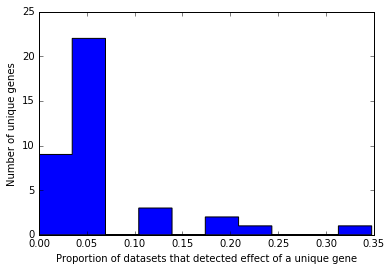

In [24]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
plt.hist(transformed_subset.s_proportion, bins = 10, histtype = 'stepfilled')
ax.set_xlabel('Proportion of datasets that detected effect of a unique gene')
ax.set_ylabel('Number of unique genes')
plt.savefig('simulations_output/distribution_of_s_proportion.png', bbox_inches = "tight", dpi = 300)  

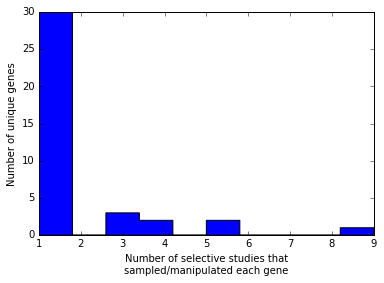

In [25]:
fig, ax = plt.subplots()
temp = transformed_subset.s_source.apply(lambda x: len(x))
plt.hist(temp, bins = 10, histtype = 'stepfilled')
ax.set_xlabel('Number of selective studies that\nsampled/manipulated each gene')
ax.set_ylabel('Number of unique genes')
plt.savefig('simulations_output/num_s_source_per_unique_gene.png', bbox_inches = "tight", dpi = 300) 